In [25]:
# connect with google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# import libraries
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [27]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [28]:
# class Generator

import torch.nn as nn
import torch
import torch.nn.functional as F


def generator_conv(in_channel, out_channel, kernel_size=3, stride=2, padding=1, batch_norm=True, bias=False,
                   type='encoder'):
    layers = []

    if type == 'encoder':
        layers = [
            nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)]

        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channel))
        else:
            pass


    elif type == 'decoder':
        layers = [nn.ConvTranspose2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride, padding=padding,
                                     bias=bias)]

        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channel))
        else:
            pass

    return nn.Sequential(*layers)


class Generator(nn.Module):
    def __init__(self, in_channel=3, feature=64):
        super(Generator, self).__init__()

        # U-NET encoder part
        self.en_conv1 = generator_conv(in_channel, feature, kernel_size=4, stride=2, padding=1, batch_norm=False,
                                       bias=False, type='encoder')
        self.en_conv2 = generator_conv(feature, feature * 2, kernel_size=4, stride=2, padding=1, batch_norm=True,
                                       bias=False, type='encoder')
        self.en_conv3 = generator_conv(feature * 2, feature * 4, kernel_size=4, stride=2, padding=1, batch_norm=True,
                                       bias=False, type='encoder')
        self.en_conv4 = generator_conv(feature * 4, feature * 8, kernel_size=4, stride=2, padding=1, batch_norm=True,
                                       bias=False, type='encoder')
        self.en_conv5 = generator_conv(feature * 8, feature * 8, kernel_size=4, stride=2, padding=1, batch_norm=True,
                                       bias=False, type='encoder')
        self.en_conv6 = generator_conv(feature * 8, feature * 8, kernel_size=4, stride=2, padding=1, batch_norm=True,
                                       bias=False, type='encoder')
        self.en_conv7 = generator_conv(feature * 8, feature * 8, kernel_size=4, stride=2, padding=1, batch_norm=True,
                                       bias=False, type='encoder')

        self.en_conv8 = generator_conv(feature * 8, feature * 8, kernel_size=4, stride=2, padding=1, batch_norm=False,
                                       bias=False, type='encoder')

        # U-Net decoder part
        self.dec_conv1 = generator_conv(feature * 8, feature * 8, kernel_size=4, stride=2, padding=1, batch_norm=True,
                                        bias=False, type='decoder')
        self.dec_conv2 = generator_conv(feature * 8 * 2, feature * 8, kernel_size=4, stride=2, padding=1,
                                        batch_norm=True, bias=False, type='decoder')
        self.dec_conv3 = generator_conv(feature * 8 * 2, feature * 8, kernel_size=4, stride=2, padding=1,
                                        batch_norm=True, bias=False, type='decoder')
        self.dec_conv4 = generator_conv(feature * 8 * 2, feature * 8, kernel_size=4, stride=2, padding=1,
                                        batch_norm=True, bias=False, type='decoder')
        self.dec_conv5 = generator_conv(feature * 8 * 2, feature * 4, kernel_size=4, stride=2, padding=1,
                                        batch_norm=True, bias=False, type='decoder')
        self.dec_conv6 = generator_conv(feature * 4 * 2, feature * 2, kernel_size=4, stride=2, padding=1,
                                        batch_norm=True, bias=False, type='decoder')
        self.dec_conv7 = generator_conv(feature * 2 * 2, feature, kernel_size=4, stride=2, padding=1, batch_norm=True,
                                        bias=False, type='decoder')

        self.dec_conv8 = generator_conv(feature * 2, in_channel, kernel_size=4, stride=2, padding=1, batch_norm=False,
                                        bias=False, type='decoder')

    def forward(self, input):
        # encoder forward
        out_enc1 = F.leaky_relu(self.en_conv1(input), 0.2)
        out_enc2 = F.leaky_relu(self.en_conv2(out_enc1), 0.2)
        out_enc3 = F.leaky_relu(self.en_conv3(out_enc2), 0.2)
        out_enc4 = F.leaky_relu(self.en_conv4(out_enc3), 0.2)
        out_enc5 = F.leaky_relu(self.en_conv5(out_enc4), 0.2)
        out_enc6 = F.leaky_relu(self.en_conv6(out_enc5), 0.2)
        out_enc7 = F.leaky_relu(self.en_conv7(out_enc6), 0.2)
        out_enc8 = F.relu(self.en_conv8(out_enc7))

        # decoder forward

        out_dec1 = F.dropout(self.dec_conv1(out_enc8), 0.5, training=True)
        out_dec1 = torch.cat([out_dec1, out_enc7], dim=1)
        out_dec1 = F.relu(out_dec1)

        out_dec2 = F.dropout(self.dec_conv2(out_dec1), 0.5, training=True)
        out_dec2 = torch.cat([out_dec2, out_enc6], dim=1)
        out_dec2 = F.relu(out_dec2)

        out_dec3 = F.dropout(self.dec_conv3(out_dec2), 0.5, training=True)
        out_dec3 = torch.cat([out_dec3, out_enc5], dim=1)
        out_dec3 = F.relu(out_dec3)

        out_dec4 = self.dec_conv4(out_dec3)
        out_dec4 = torch.cat([out_dec4, out_enc4], dim=1)
        out_dec4 = F.relu(out_dec4)

        out_dec5 = self.dec_conv5(out_dec4)
        out_dec5 = torch.cat([out_dec5, out_enc3], dim=1)
        out_dec5 = F.relu(out_dec5)

        out_dec6 = self.dec_conv6(out_dec5)
        out_dec6 = torch.cat([out_dec6, out_enc2], dim=1)
        out_dec6 = F.relu(out_dec6)

        out_dec7 = self.dec_conv7(out_dec6)
        out_dec7 = torch.cat([out_dec7, out_enc1], dim=1)
        out_dec7 = F.relu(out_dec7)

        out_dec8 = self.dec_conv8(out_dec7)

        output = torch.tanh(out_dec8)

        return output

In [29]:
# class Discriminator

import torch.nn as nn
import torch
import torch.nn.functional as F


def disc_conv(in_channel, out_channel, kernel_size=3, stride=2, padding=1, padding_mode="reflect", batch_norm=True,
              bias=False, first_layer=False):
    if first_layer:
        layers = [
            nn.Conv2d(in_channel * 2, out_channel, kernel_size, stride=stride, padding=padding, padding_mode="reflect",
                      bias=bias)]
    else:
        layers = [
            nn.Conv2d(in_channel, out_channel, kernel_size, stride=stride, padding=padding, padding_mode="reflect",
                      bias=bias)]

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channel))

    return nn.Sequential(*layers)


class Discriminator(nn.Module):
    def __init__(self, in_channel=3, features=[64, 128, 256, 512]):
        super(Discriminator, self).__init__()

        self.disc_conv1 = disc_conv(in_channel, features[0], kernel_size=4, stride=2, padding=1, padding_mode='reflect',
                                    batch_norm=False, bias=False, first_layer=True)
        self.disc_conv2 = disc_conv(features[0], features[1], kernel_size=4, stride=2, padding=1,
                                    padding_mode='reflect', batch_norm=True, bias=False, first_layer=False)
        self.disc_conv3 = disc_conv(features[1], features[2], kernel_size=4, stride=2, padding=1,
                                    padding_mode='reflect', batch_norm=True, bias=False, first_layer=False)
        self.disc_conv4 = disc_conv(features[2], features[3], kernel_size=4, stride=2, padding=1,
                                    padding_mode='reflect', batch_norm=True, bias=False, first_layer=False)

        self.disc_conv5 = disc_conv(features[3], 1, kernel_size=4, stride=1, padding=1, padding_mode='reflect',
                                    batch_norm=False, bias=False, first_layer=False)

    def forward(self, input, label):
        out = torch.cat([input, label], dim=1)

        out = F.leaky_relu(self.disc_conv1(out), 0.2)
        out = F.leaky_relu(self.disc_conv2(out), 0.2)
        out = F.leaky_relu(self.disc_conv3(out), 0.2)
        out = F.leaky_relu(self.disc_conv4(out), 0.2)

        out = torch.sigmoid(self.disc_conv5(out))

        return out

In [30]:
import torch
import torch.nn as nn

# custom weights initialization called on netG and netD

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [31]:
import torch
from torchvision.utils import save_image

def save_some_examples(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x, y
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5  # remove normalization
        save_image(y_fake, folder + f"/y_gen_{epoch}.png")
        save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        if epoch == 1:
            save_image(y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
    gen.train()


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=device)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [32]:
import torch
from tqdm import tqdm


def train(netD, netG, dataloader, opt_D, opt_G, l1_loss, bce, g_scaler, d_scaler):

    loop = tqdm(dataloader, leave=True)

    for idx, (x, y) in enumerate(loop):
        x = x
        y = y

        # Train Discriminator
        with torch.cuda.amp.autocast():
            y_fake = netG(x)
            D_real = netD(x, y)
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake = netD(x, y_fake.detach())
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss) / 2

        netD.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_D)
        d_scaler.update()

        # Train generator
        with torch.cuda.amp.autocast():
            D_fake = netD(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1_loss(y_fake, y) * 100 # 100 = L1_LAMBDA
            G_loss = G_fake_loss + L1

        opt_G.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_G)
        g_scaler.update()

        if idx % 10 == 0:
            loop.set_postfix(
                D_real=torch.sigmoid(D_real).mean().item(),
                D_fake=torch.sigmoid(D_fake).mean().item(),
            )

In [33]:
# custom data class
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset
from skimage.util import random_noise


def gen_new_img(image):
  # noise_factor = 0.001
  # noised_image = image + noise_factor * np.random.normal(loc = 0., scale = 1., size = image.shape)

  noised_image = random_noise(image, mode='s&p',amount=0.08)
  
  return noised_image


class CustomData(Dataset):
  def __init__(self, root_dir, transform):
    super().__init__()

    self.root_dir = root_dir
    self.transform = transform

    self.files_list = os.listdir(self.root_dir)

  def __len__(self):
    return len(self.files_list)

  def __getitem__(self, index):
    image_file = self.files_list[index]
    image_path = os.path.join(self.root_dir, image_file)
    image = np.array(Image.open(image_path))

    # we use "image" as target and we generate a "new image" to use as input image
    
    input_image = gen_new_img(image) # func take and return numpy array image 

    # https://stackoverflow.com/questions/55319949/pil-typeerror-cannot-handle-this-data-type
    input_image = Image.fromarray((input_image* 255).astype(np.uint8))
    image = Image.fromarray(image)

    input_image = self.transform(input_image)
    target_image = self.transform(image)

    return input_image, target_image

In [34]:
# Parameters
lr = 2e-4
batch_size = 4
image_size = 256
number_of_channel = 3
num_epochs = 20

In [35]:
# Transformer
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

# Datasets
train_dataset = CustomData(root_dir='/content/drive/MyDrive/data/train/images', transform=transform)
val_dataset = CustomData(root_dir='/content/drive/MyDrive/data/valid/images', transform=transform)

In [36]:
train_dataset.__len__()

986

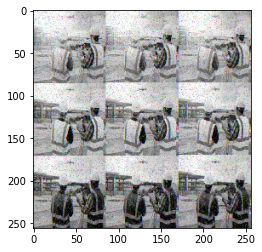

In [37]:
input, target = train_dataset.__getitem__(500)

input = input.reshape(image_size, image_size, number_of_channel)
target = target.reshape(image_size, image_size, number_of_channel)

from matplotlib import pyplot as plt

plt.imshow(input)
plt.show()

In [38]:
val_dataset.__len__()

246

In [39]:
# Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [40]:
"""   MAIN BLOCK   """

# Discriminator Network and optimizer
netD = Discriminator(in_channel=3, features=[64, 128, 256, 512])
weights_init(netD)
opt_D = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))

# Generator Network and optimizer
netG = Generator(in_channel=3, feature=64)
weights_init(netG)
opt_G = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

# Loss
BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()

# Scalers
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()


for epoch in range(num_epochs):
    train(netD, netG, train_dataloader, opt_D, opt_G, l1_loss=L1_LOSS, bce=BCE, g_scaler=g_scaler, d_scaler=d_scaler)

    if epoch % 5 == 0:
        save_checkpoint(netG, opt_G, filename="gen.pth.tar")
        save_checkpoint(netD, opt_D, filename="disc.pth.tar")

    save_some_examples(netG, val_dataloader, epoch, folder="evaluation")

/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
  0%|          | 0/247 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|██████████| 247/247 [27:53<00:00,  6.78s/it, D_fake=0.502, D_real=0.633]


=> Saving checkpoint
=> Saving checkpoint


 49%|████▊     | 120/247 [13:40<14:28,  6.84s/it, D_fake=0.501, D_real=0.501]


KeyboardInterrupt: ignored